In [1]:
import numpy as np
import rosatX as rx
import matplotlib.pyplot as plt
from matplotlib import rc

rc("font", **{"family": "sans-serif", "sans-serif": ["Helvetica"]})
rc("text", usetex=True)

params_all = ["lMc", "gamma", "alpha_T", "eta_b"]
param_names = [r"$\log_{10}M_c$",
               r"$\Gamma$",
               r"$\alpha_T$",
               r"$\eta_b$",
               r"$Z$"]

### Initialising the setup

In [2]:
like = rx.ROSATxLike(bins=[2])
clm = like.cl_meta[0]

params_fiducial = {"lMc": 14.0,
                   "gamma": 1.17,
                   "alpha_T": 1.0,
                   "eta_b": 0.5}

def preds(pname, nval):
    p0, pf = like.priors[pname]
    pvals = np.linspace(p0, pf, nval)
    pred = []
    for p in pvals:
        pars = params_fiducial.copy()
        pars[pname] = p
        pred.append(like.get_model(**pars)[0])
    return np.array(pred).squeeze()

nval = 8
predictions = {k: preds(k, nval) for k in params_all}

### Metallicity

In [3]:
Zs = np.array([0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45])
ts = []
for Z in Zs:
    like_metal = rx.ROSATxLike(bins=[2], Zmetal=Z)
    ts.append(like_metal.get_model(**params_fiducial)[0])
predictions["Z"] = np.array(ts).squeeze()

params = params_all.copy()
params.append("Z")

## Plots

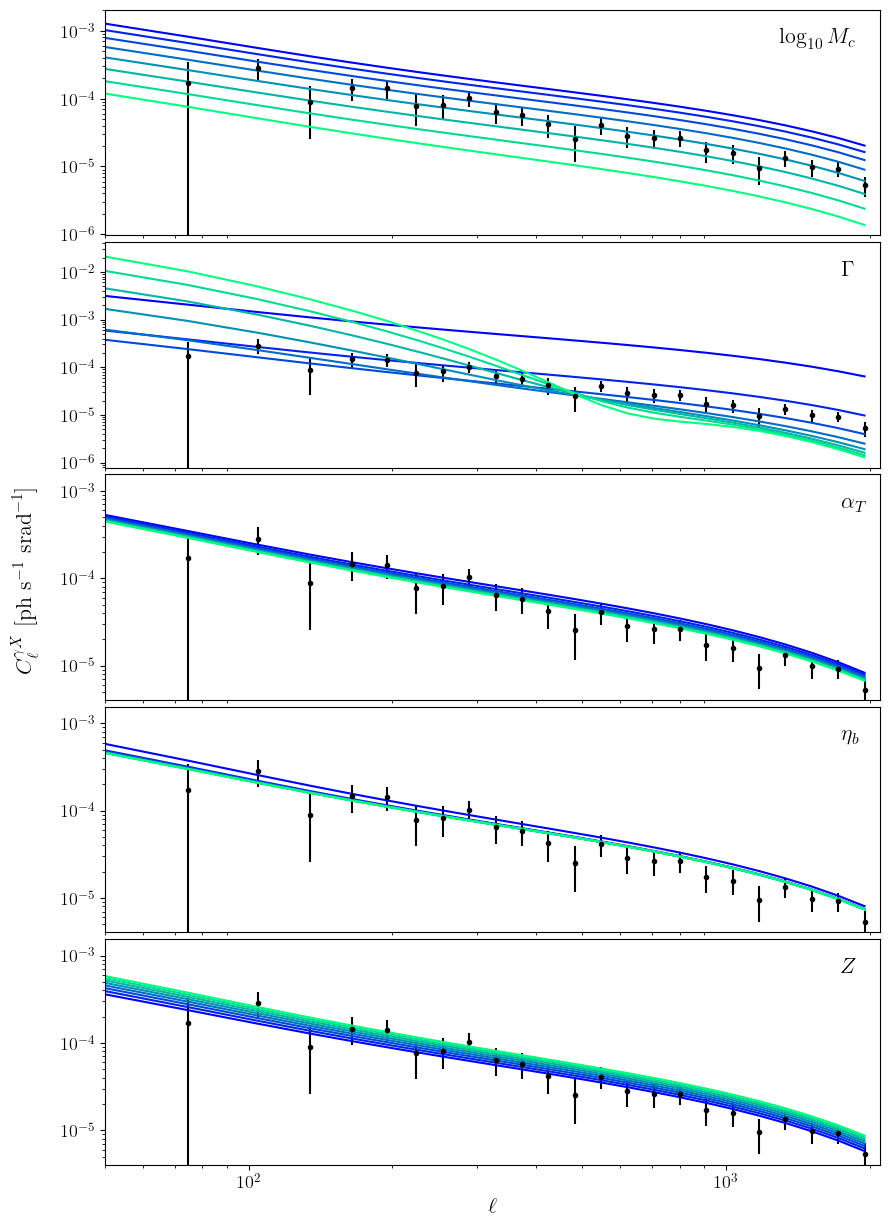

In [4]:
mosaic = """
A
B
C
D
E
"""
color = plt.cm.winter(np.linspace(0, 1, nval))

fig, axes = plt.subplot_mosaic(mosaic=mosaic, figsize=(10, 15))
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for i, a in enumerate(["A", "B", "C", "D", "E"]):
    ax = axes[a]
    ax.errorbar(clm["ls"],
                clm["cld"],
                yerr=np.sqrt(np.diag(clm["cov"])), fmt="k.")
    ts = predictions[params[i]]
    for t, c in zip(ts, color):
        ax.plot(clm["ls"], t, "-", c=c)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlim([50, 2100])
    ax.tick_params(axis="both", labelsize=13)
    if param_names[i] == r"$\log_{10}M_c$":
        x = 0.87
    else:
        x = 0.95
    ax.text(x, 0.85,
            param_names[i],
            transform=ax.transAxes,
            fontsize=16)
axes["A"].set_xticks([])
axes["B"].set_xticks([])
axes["C"].set_xticks([])
axes["D"].set_xticks([])
axes["E"].set_xlabel(r"$\ell$", fontsize=16)

fig.supylabel(
    r"$C_\ell^{\gamma X}\,\,[{\rm ph\,\,s^{-1}\,\,{\rm srad}^{-1}}]$",
    fontsize=16, x=0.03)

plt.savefig("Plots/Cls_params.pdf", bbox_inches="tight")

## Check the effect of clumping

In [5]:
Clumping = rx.ROSATxLike()
cls_Clumping = Clumping.get_model(**params_fiducial)

NoClumping = rx.ROSATxLike(with_clumping=False)
cls_NoClumping = NoClumping.get_model(**params_fiducial)

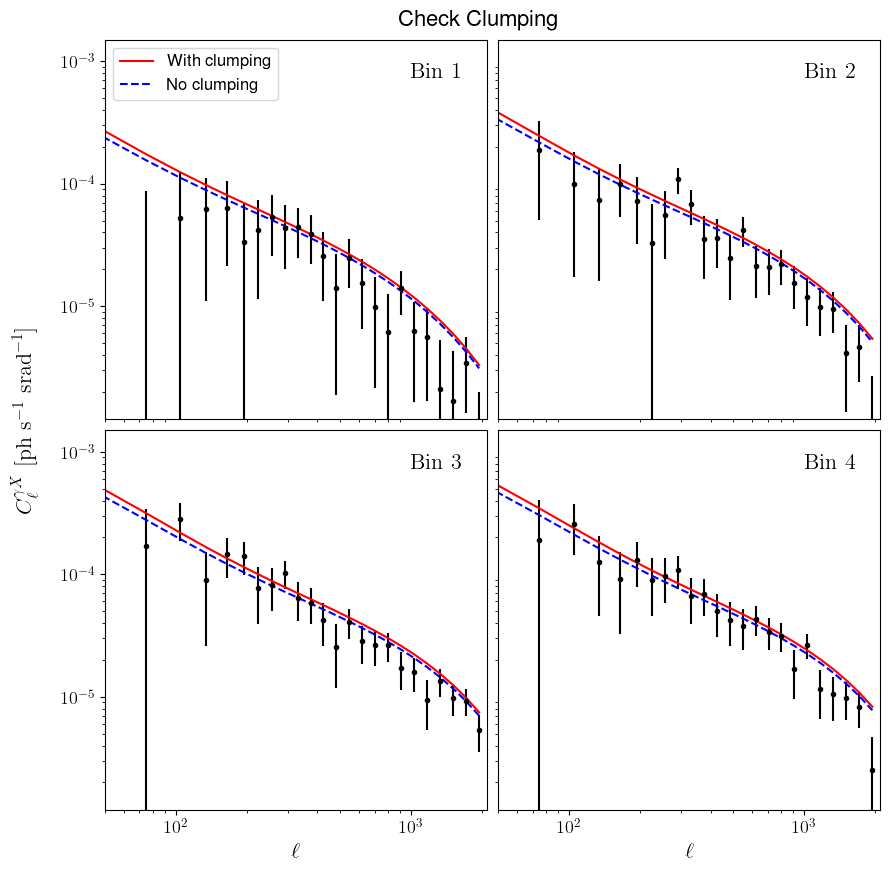

In [6]:
mosaic = [["A", "B"],
          ["C", "D"]]
pattern = ["A", "B", "C", "D"]

fig, axes = plt.subplot_mosaic(mosaic=mosaic, figsize=(10, 10))
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for i, d in enumerate(Clumping.cl_meta):
    ax = axes[pattern[i]]
    ax.errorbar(d["ls"],
                d["cld"],
                yerr=np.sqrt(np.diag(d["cov"])), fmt="k.")
    ax.plot(d["ls"], cls_Clumping[i], "r-", label="With clumping")
    ax.plot(d["ls"], cls_NoClumping[i], "b--", label="No clumping")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim([1.2e-6, 1.5e-3])
    ax.set_xlim([50, 2100])
    ax.tick_params(axis="both", labelsize=13)
    ax.text(0.8, 0.9,
            r"${\rm Bin\,\,%d}$" % (i + 1),
            transform=ax.transAxes, fontsize=16)
axes["A"].legend(loc="upper left", fontsize=12)
axes["A"].set_xticks([])
axes["B"].set_xticks([])
axes["B"].set_yticks([])
axes["D"].set_yticks([])

fig.suptitle("Check Clumping",
             fontsize=16, y=0.91)
fig.supylabel(
    r"$C_\ell^{\gamma X}\,\,[{\rm ph\,\,s^{-1}\,\,{\rm srad}^{-1}}]$",
    fontsize=16, x=0.03)
for m in ["C", "D"]:
    axes[m].set_xlabel(r"$\ell$", fontsize=16)

plt.savefig("Plots/Cls_clumping.pdf", bbox_inches="tight")

## Check the dependence on $\log_{10}T_{\rm AGN}$

In [7]:
like_TAGN = rx.ROSATxLike(params_vary=["logTAGN"],
                          priors={"logTAGN": [7.5, 8.2]})

pars = [{"logTAGN": 7.5},
        {"logTAGN": 7.6},
        {"logTAGN": 7.7},
        {"logTAGN": 7.8},
        {"logTAGN": 7.9},
        {"logTAGN": 8.0},
        {"logTAGN": 8.1},
        {"logTAGN": 8.2}]

clms = [like_TAGN.get_model(**p) for p in pars]

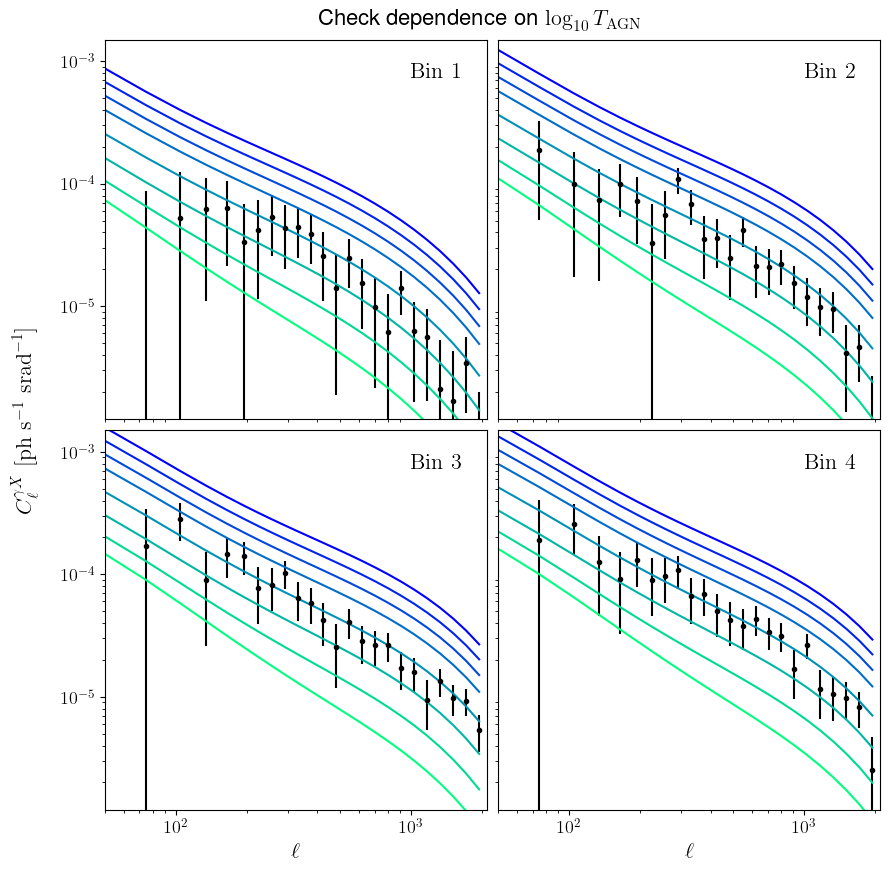

In [8]:
mosaic = [["A", "B"],
          ["C", "D"]]
pattern = ["A", "B", "C", "D"]

fig, axes = plt.subplot_mosaic(mosaic=mosaic, figsize=(10, 10))
plt.subplots_adjust(hspace=0.03, wspace=0.03)
for i, d in enumerate(like_TAGN.cl_meta):
    ax = axes[pattern[i]]
    ax.errorbar(d["ls"],
                d["cld"],
                yerr=np.sqrt(np.diag(d["cov"])), fmt="k.")
    for t, c in zip(clms, color):
        ax.plot(clm["ls"], t[i], "-", c=c)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_ylim([1.2e-6, 1.5e-3])
    ax.set_xlim([50, 2100])
    ax.tick_params(axis="both", labelsize=13)
    ax.text(0.8, 0.9,
            r"${\rm Bin\,\,%d}$" % (i + 1),
            transform=ax.transAxes, fontsize=16)
axes["A"].set_xticks([])
axes["B"].set_xticks([])
axes["B"].set_yticks([])
axes["D"].set_yticks([])

fig.suptitle("Check dependence on $\log_{10}T_{\mathrm{AGN}}$",
             fontsize=16, y=0.91)
fig.supylabel(
    r"$C_\ell^{\gamma X}\,\,[{\rm ph\,\,s^{-1}\,\,{\rm srad}^{-1}}]$",
    fontsize=16, x=0.03)
for m in ["C", "D"]:
    axes[m].set_xlabel(r"$\ell$", fontsize=16)

plt.savefig("Plots/Cls_TAGN.pdf", bbox_inches="tight")